In [54]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [55]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


In [56]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv("Company Stock and Investment.csv")

In [57]:
data

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013
...,...,...,...,...,...
1979,09-11-2017,0.005984,0.000623,-0.002043,-0.003310
1980,10-11-2017,-0.007173,-0.000389,-0.006880,-0.003348
1981,13-11-2017,0.000352,-0.004944,-0.004008,0.003395
1982,14-11-2017,-0.019376,-0.002621,-0.015118,0.006793


Visualize the per day closing price of the stock.

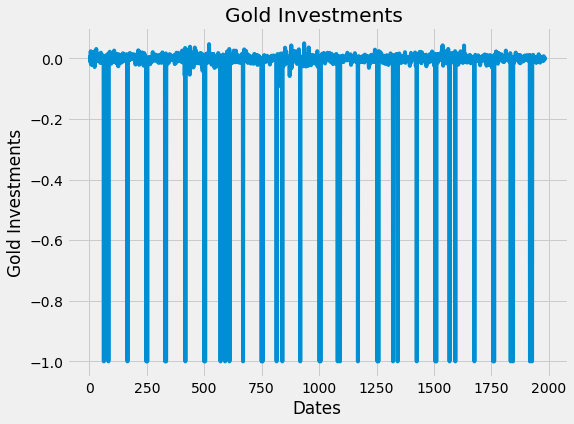

In [58]:

plt.figure(figsize=(8,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Gold Investments')
plt.plot(data['Gold Investments'])
plt.title('Gold Investments ')
plt.show()

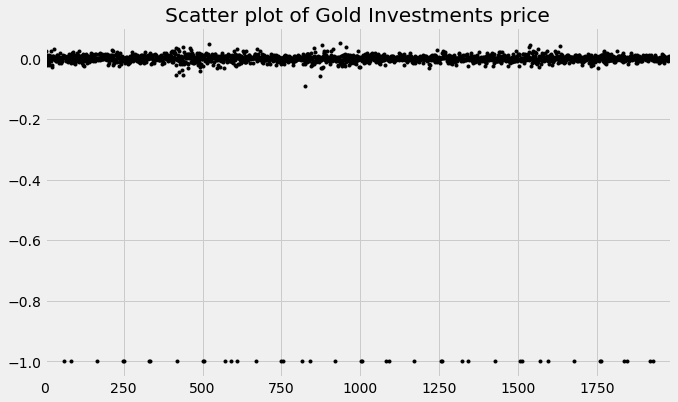

In [59]:
df_close = data['Gold Investments']
df_close.plot(style='k.')
plt.title('Scatter plot of Gold Investments price')
plt.show()

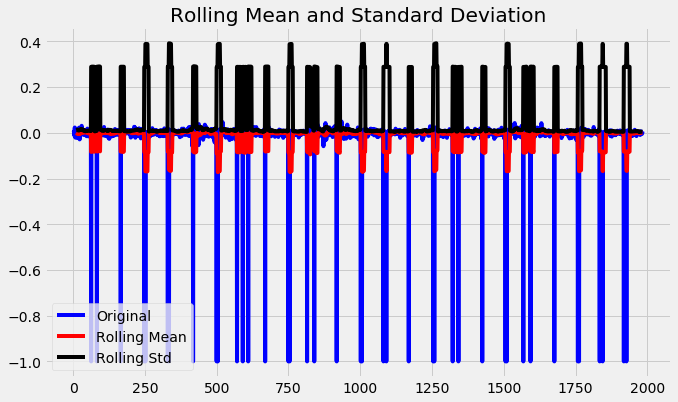

Results of dickey fuller test
Test Statistics               -1.590685e+01
p-value                        8.208406e-29
No. of lags used               7.000000e+00
Number of observations used    1.976000e+03
critical value (1%)           -3.433664e+00
critical value (5%)           -2.863004e+00
critical value (10%)          -2.567549e+00
dtype: float64


In [60]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

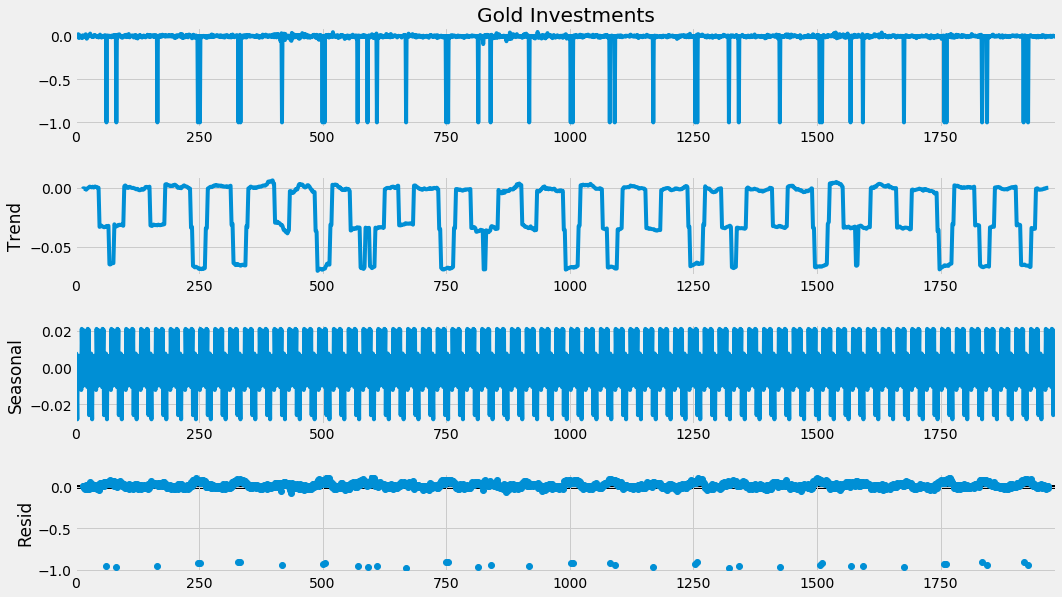

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_close, model='additive', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


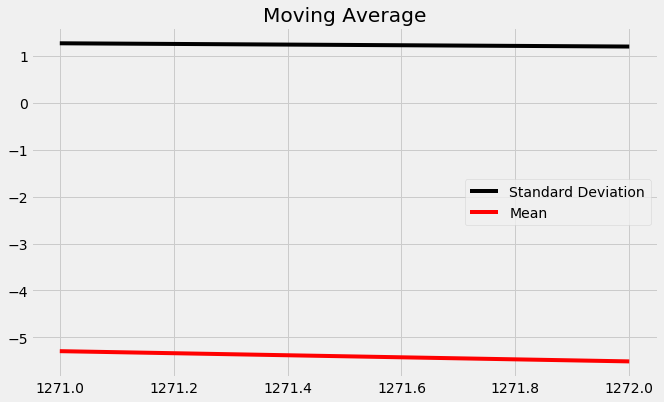

In [62]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

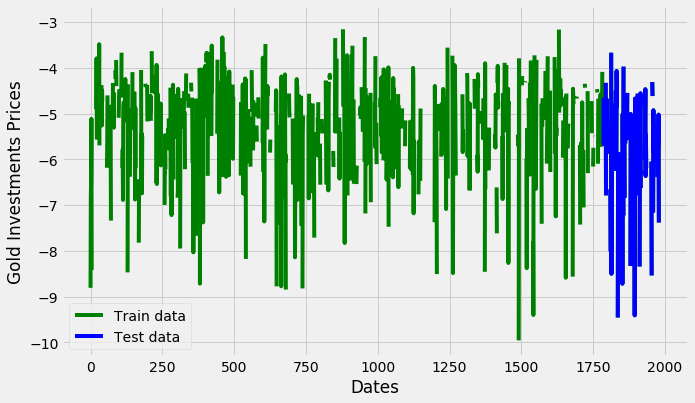

In [63]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Gold Investments Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

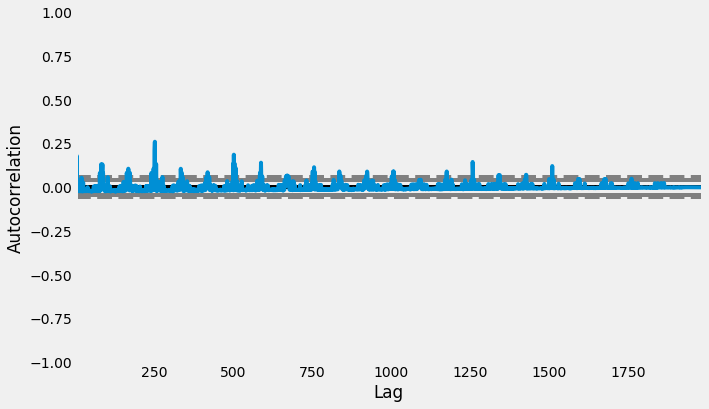

In [64]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Gold Investments'])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [66]:
fig = plt.fig(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Gold Investments'].iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Gold Investments'].iloc[13:],lags=40,ax=ax2)



AttributeError: module 'matplotlib.pyplot' has no attribute 'fig'

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model=ARIMA(data['Gold Investments'],order=(1,1,1))
model_fit=model.fit()

In [ ]:
model_fit.summary()

In [ ]:
data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data[['Gold Investments','forecast']].plot(figsize=(12,8))

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(data['Gold Investments'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['Gold Investments','forecast']].plot(figsize=(12,8))

In [ ]:

from pandas.tseries.offsets import DateOffset

future_dates=[data.index[-1] + DateOffset(months=x)for x in range(0,24)]
future_datest_data=pd.DataFrame(index=Future_dates[1:],columns=data.columns)
future_datest_df.tail()

In [ ]:
future_data=pd.concat([data,future_datest_data])

In [ ]:
future_data['forecast']=result.predict(start = 104,end = 120,dynamic = True)
future_data[['Gold Investments','forecast']].plot(figsize=(12,8))